# Bukowski's Poems Sentiment Analysis

As a byproduct of the neural network project that attempts to write a Bukowski poem, I ended up with this pickle file with a large sample of its poems (1363). I'll use the data to perform basic sentiment analysis on the writings, and see what insights can be extracted from them.

We start by reading the file and loading libraries...

In [54]:
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from collections import Counter
import numpy as np
import pandas as pd
from tsne import bh_sne
import string
import gensim

from afinn import Afinn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 20.0)
plt.rcParams['axes.titlesize'] = 20
sns.set_style('whitegrid')

In [55]:
## The aforementioned pickle file.
content = pd.read_pickle('data/content.pkl')

In [56]:
## Flatten all sentences into a single array, also remove START & STOP.
text_flat = [word for line in content['tokens'] for word in line]

In [57]:
## Remove stopwords, punctuations and symbols. 
stop_words = stopwords.words('english') + list(string.punctuation) + \
    ['start_symbol','stop_symbol']

text_stop = [word.lower() for word in text_flat \
            if (word.lower() not in stop_words)]
#and len(word) > 3
## Now we stem the words, and only keep the set.
ps = PorterStemmer()
text_stem = Counter([ps.stem(word) for word in text_stop])

## Most Common Stems and Word Polarity
First, I'll look at the most common stemmed words used in his texts. A stem is the form of the word to which affixes can be attached, like run → (runner, running). By doing the analysis this way we can get a sense of the subjects Bukowski focuses on the most.

To make the analysis more interesting, I'll remove all stopwords and use the `Afinn` package to assign a [-5,5] polarity score to each of the words. After this we can filter neutral terms such as verbs (i.e. like, go, know) and uninteresting nouns (people, street, man).

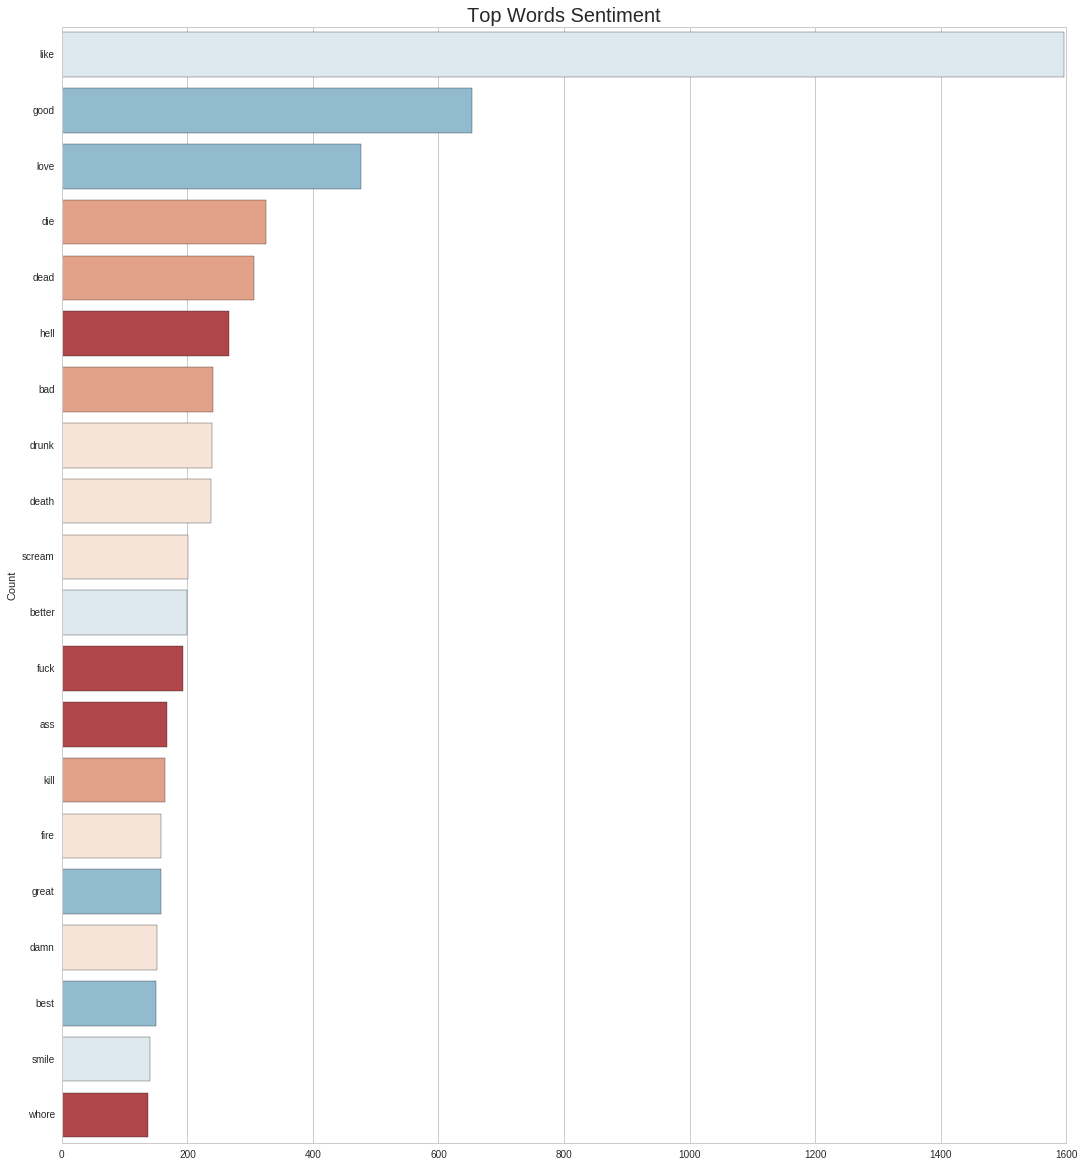

In [58]:
## Word sentiment scorer.
afinn = Afinn()
commons = pd.DataFrame({'word': [word[0] for word in text_stem.most_common(240)],
                        'count': [word[1] for word in text_stem.most_common(240)],
                        'score' : [afinn.score(word[0]) for word in text_stem.most_common(240)]})

## Get only non-neutral words.
nn_commons = commons[~commons['score'].isin([-1,0,1])]
ix = nn_commons.word
nn_commons = nn_commons.pivot(index='word', columns='score', values='count').reindex(ix)

## Generate palette and plot.
n = len(nn_commons.columns)
palette = sns.color_palette("RdBu", n_colors=n+1)

i=0
for col in nn_commons.columns:
    sns.barplot(x=col, y='word', data=nn_commons.reset_index(), \
                color=palette[i], order=nn_commons.index)
    i+=1

plt.title('Top Words Sentiment')
plt.ylabel('Count')
plt.xlabel('')

In general, the terms tends to the negative polarity, and 2 out of the top 3 positive ones might have been missclassified: *like* as a preposition/adjective/adverb should have no polarity; *love* neither needs not to be positive, as when the author writes about it sometimes the tone is otherwise (i.e. *Love is a Dog from Hell*). Towards the end of the list we do see these more positive terms, some glimpses of hope and beauty.

The official writer's [site](https://charlesbukowski.wikispaces.com/Themes?responseToken=04ecb6aa9939fbb17d1c5f9eea062e87c) mentions **love, sex, drinking** and **dead** as themes central to his work, and this chart seems to validate it.

## References to Gender, and their Associations
Even though he regards himself as a loner, Bukowski is constantly describing encounters and interactions with new people. To extract the main subjects behind these interactions, I'll start by classifing each line in the database as *male* or *female* related, depending on the precense of the keywords listed below. To account for the fact that sentences sometimes spread over several lines, I'll investigate them in pairs. Below is an example.

`START_SYMBOL she was still a virgin STOP_SYMBOL`  
`START_SYMBOL and a very bad poetess. STOP_SYMBOL`

First, we look at how frequent these *interactions* are.

In [34]:
## Gender keywords taken from a blog I can't recall...
male_words=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend',\
                'boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers',\
                'fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom',\
                'he','himself','husband','husbands','king','male','man','mr','nephew','nephews',\
                'priest','prince','son','sons','uncle','uncles','waiter','widower','widowers'])

female_words=set(['heroine','spokeswoman','chairwoman',"women's",'actress','women',"she's",'her',\
                  'aunt','aunts','bride','daughter','daughters','female','fiancee','girl',\
                  'girlfriend','girlfriends','girls','goddess','granddaughter','grandma',\
                  'grandmother','herself','ladies','lady','lady','mom','moms','mother','mothers',\
                  'mrs','ms','niece','nieces','priestess','princess','queens','she','sister',\
                  'sisters','waitress','widow','widows','wife','wives','woman'])

In [35]:
m=0.
f=0.

m_counts = Counter()
f_counts = Counter()

for i, r in content.iterrows():
    sent = [word for line in content.loc[i:i+1,'tokens'] for word in line]
    if (not set(sent).isdisjoint(male_words)) and (set(sent).isdisjoint(female_words)):
        for wd in [nltk.pos_tag([word.lower()])[0] for word in sent \
                   if ((word.lower() not in stop_words) and len(word)>3)]:
            m_counts[wd] += 1
        m+=1
    elif (not set(sent).isdisjoint(female_words)) and (set(sent).isdisjoint(male_words)):
        for wd in [nltk.pos_tag([word.lower()])[0] for word in sent \
                   if ((word.lower() not in stop_words) and len(word)>3)]:
            f_counts[wd] += 1
        f+=1

In [36]:
print '%.2f%% of sentence are male-related.' %(m/content.shape[0]*100)
print '%.2f%% of sentence are female-related.' %(f/content.shape[0]*100)

15.43% of sentence are male-related.
9.68% of sentence are female-related.


About 25% of the lines make reference to some sort of human interaction. This seems like a reasonable estimate. Now let's investigate what other words the selected lines are correlated with. The plots below show the most common nouns occuring on them, divided by gender.

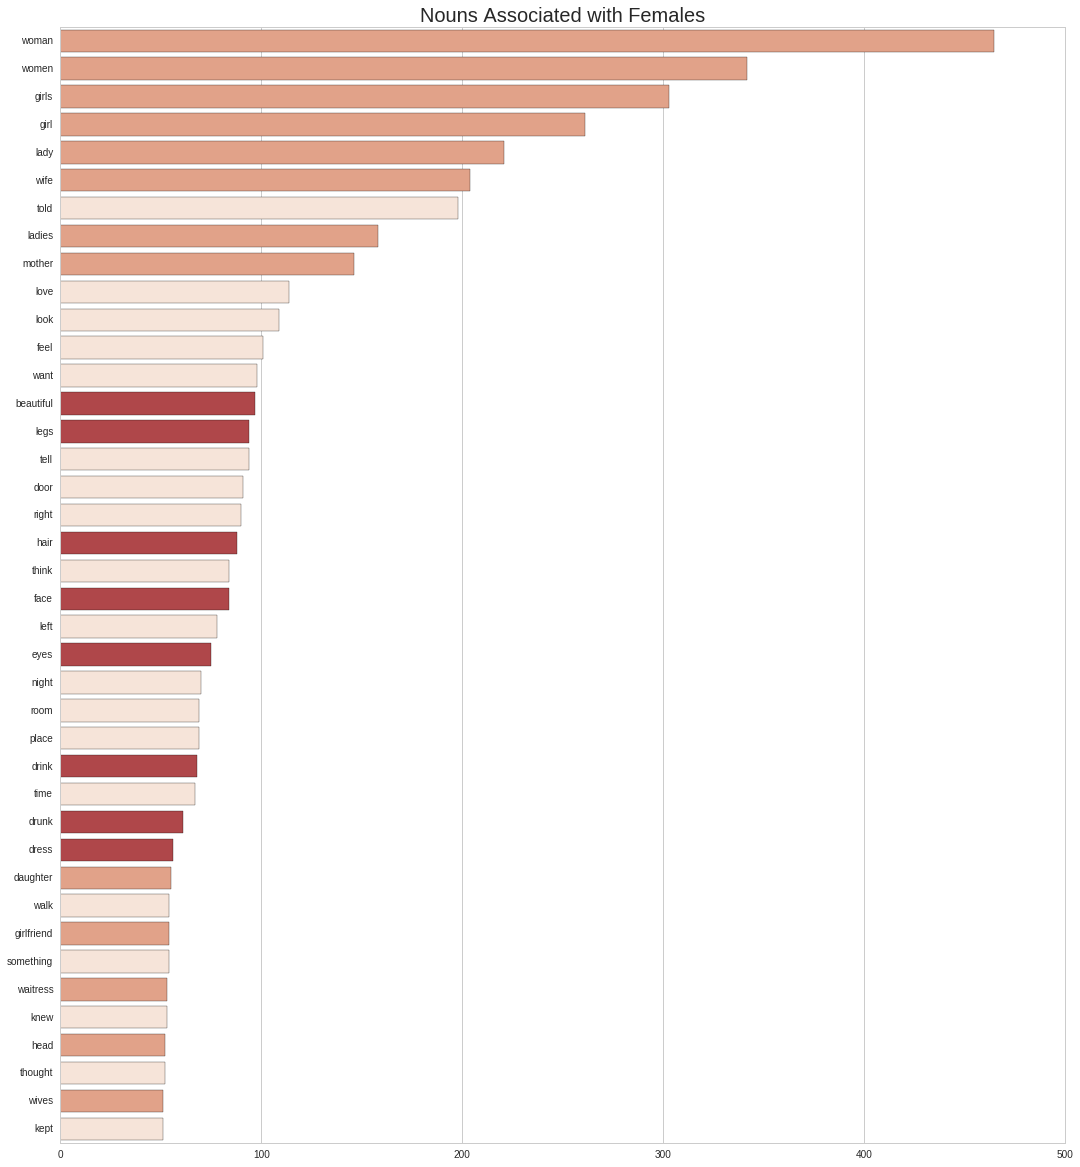

In [60]:
f_words = pd.DataFrame({ \
    'word' : [pair[0][0] for pair in f_counts.most_common() \
              if ('NN' in pair[0][1] and pair[1] > 50)], \
    'count' : [pair[1] for pair in f_counts.most_common() \
               if ('NN' in pair[0][1] and pair[1] > 50)] \
                       })

## Manual word labels.
f_words['type']=[1,1,1,1,1,1,0,1,1,0,0,0,0,2,2,0,0,0,2,0,2,0,2,0,0,0,2,0,2,2,1,0,1,0,1,0,1,0,1,0]

## Get only non-neutral words.
ix = f_words.word
f_words = f_words.pivot(index='word', columns='type', values='count').reindex(ix)

i=0
for col in f_words.columns:
    sns.barplot(x=col, y='word', data=f_words.reset_index(), \
                color=palette[2-i], order=f_words.index)
    i+=1

plt.title('Nouns Associated with Females')
plt.ylabel('')
plt.xlabel('')

Asides from the gerunds and other common words, we can see three broad categories of nouns that stand out: those that describe the woman in relationship to their role, those associated to her physical appearance, those related to alcohol. I've color-coded them mixing the last 2 together, since they are relate to Bukowski's central themes.

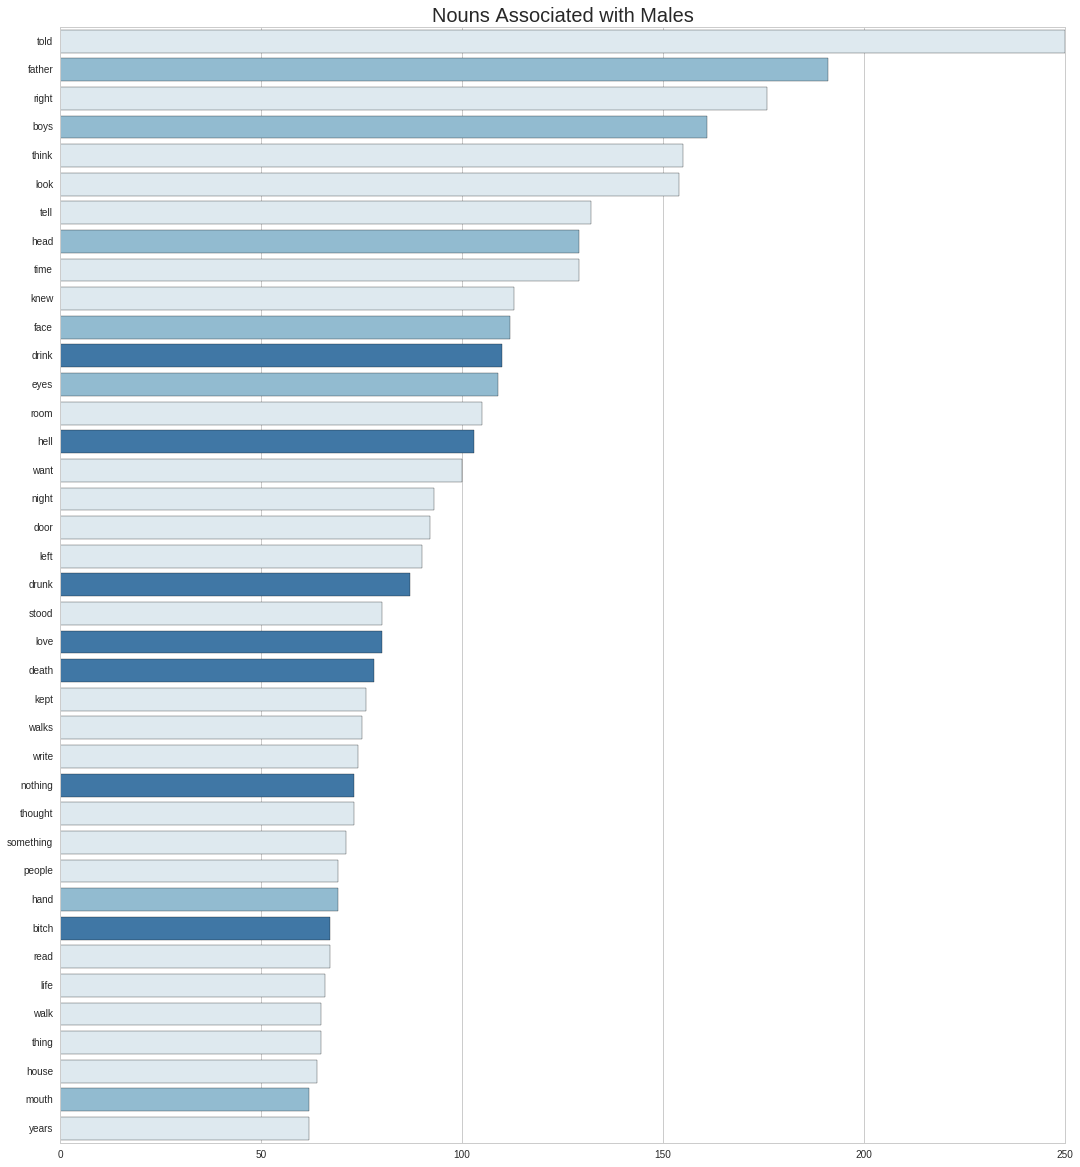

In [61]:
m_words = pd.DataFrame({ \
    'word' : [pair[0][0] for pair in m_counts.most_common() \
              if ('NN' in pair[0][1] and pair[1] > 60)], \
    'count' : [pair[1] for pair in m_counts.most_common() \
              if ('NN' in pair[0][1] and pair[1] > 60)] \
                       })
## Manual word labels.
m_words['type']=[2,1,2,1,2,2,2,1,2,2,1,0,1,2,0,2,2,2,2,0,2,0,0,2,2,2,0,2,2,2,1,0,2,2,2,2,2,1,2]

## Get only non-neutral words.
ix = m_words.word
m_words = m_words.pivot(index='word', columns='type', values='count').reindex(ix)

i=0
for col in m_words.columns:
    sns.barplot(x=col, y='word', data=m_words.reset_index(), \
                color=palette[-i-1], order=m_words.index)
    i+=1

plt.title('Nouns Associated with Males')
plt.ylabel('')
plt.xlabel('')

Here I've highlighted two different sets of words: the first one with references to roles and bodyparts, and the second most central to the writer's themes - death, drinking and sex.

Looking back at the lists, among the 'uninteresting' nouns we see 2 that consistently occur:*room* and *night*. Incidentally many of the auther's encounters with other persons occur at this place (his room) at this time.

## Word2Vec
Finally I take a look at the relationship top words have to each other. To do this, I'll take Google's pre-trained [word2vec model](https://code.google.com/archive/p/word2vec/) and extract the word vectors for the top occuring non-neutral terms. Each of these vectors is made up by 300 features, so in order to visualize them I use the `tsne` library to reduce the dimensions to 2. After this we can plot the words on a 2D space.

In [12]:
## Load Google's model.
gmodel = gensim.models.Word2Vec.load_word2vec_format('/model/GoogleNews-vectors-negative300.bin', \
                                                     binary=True)  

In [79]:
## Get more words to plot.
commons_ext = pd.DataFrame({'word': [word[0] for word in text_stem.most_common(700)],
                        'count': [word[1] for word in text_stem.most_common(700)],
                        'score' : [afinn.score(word[0]) for word in text_stem.most_common(700)]})

## Get only non-neutral words.
nn_commons_ext = commons_ext[~commons_ext['score'].isin([0])]

## Get word2vec dimensions for top words.
word_x = []
word_y = []
word_c = []
word_s = []

for i, r in nn_commons_ext.iterrows():
    if r['word'] in gmodel.vocab:
        word_x.append(gmodel[r['word'].encode('utf-8')])
        word_y.append(r['word'])
        word_c.append(str(r['score']))
        word_s.append(int(r['count']))
        
word_x = np.array(word_x).astype('float64')

## Use t-SNE to reduce dimensions.
word_viz = bh_sne(word_x, perplexity=8)

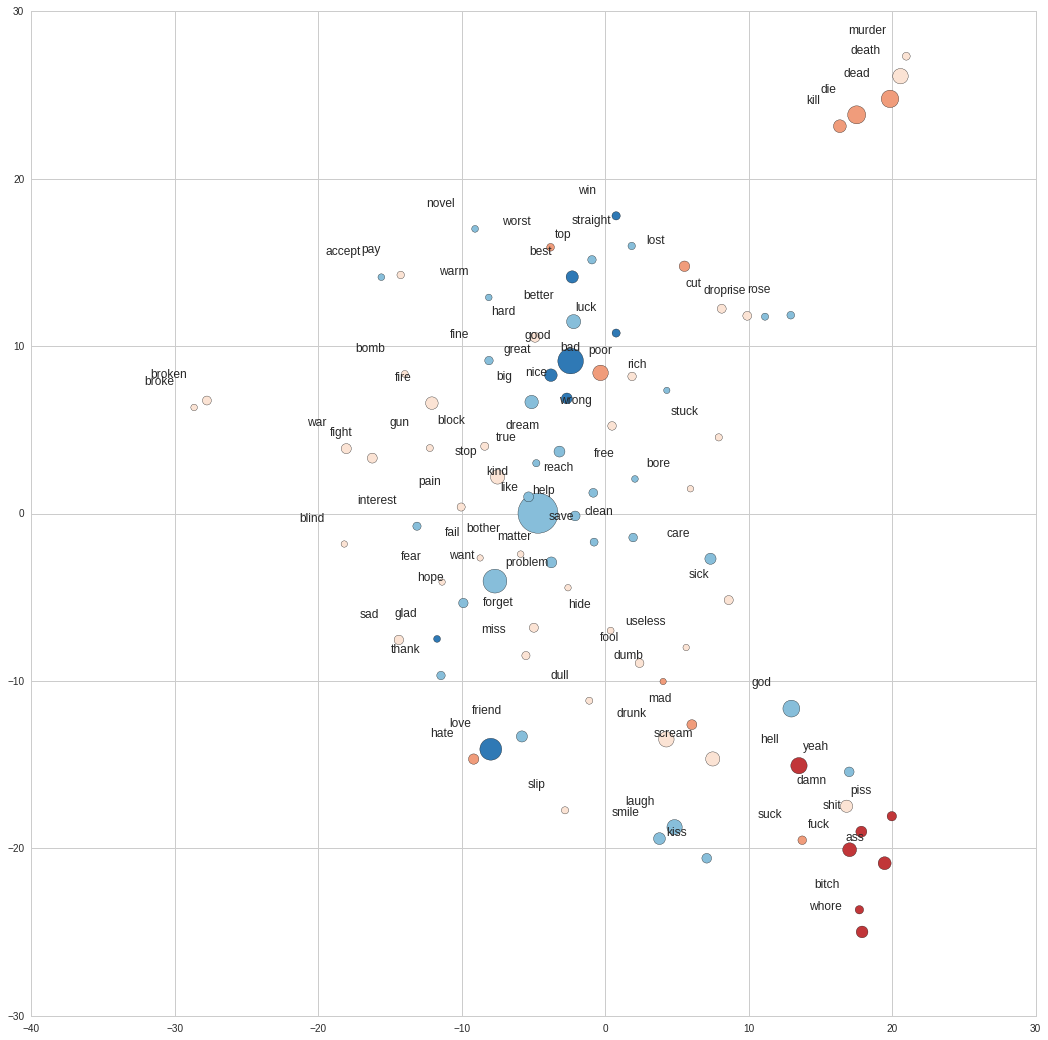

In [81]:
plt.rcParams['figure.figsize'] = (18.0, 18.0)
cmap = ListedColormap(palette)
plt.scatter(word_viz[:, 0], word_viz[:, 1], c=word_c, s=word_s, cmap=cmap)

for label, x, y in zip(word_y, word_viz[:, 0], word_viz[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20), fontsize=12,
        textcoords = 'offset points', ha = 'right', va = 'bottom'
        )

We observe a **sex** related cluster at the bottom left side of the plot, and a second **dead** related one on the top. There's also another group near the sex cluster that we can associate with **love**, made up of words such as  kiss, smile, laught and friend. We don't see too much of **alcohol**, which is probably due to these words being filtered out due to their netural sentiment. 

As further development, it would be interesting to train the word2vec model with the actual text from the poems/novels, to see how the relationships change.